<a href="https://colab.research.google.com/github/Sawera123a/Twitter-sentiment-analysis/blob/main/Twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Tweeter sentiment analysis

import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
# Parameters
CSV_PATH = "/content/Tweets[2].csv"   # Dataset filename
RANDOM_STATE = 42
MODEL_OUT = "airline_sentiment_lr.joblib"
VECT_OUT = "tfidf_vectorizer_airline.joblib"

# Preprocessing helpers
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|https\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)               # remove mentions
    text = re.sub(r"#", "", text)                  # remove hashtag symbol
    text = re.sub(r"[^a-z\s]", " ", text)          # keep only letters
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

In [40]:
# Load Airline Sentiment Data
df = pd.read_csv(CSV_PATH)

# Keep only needed columns
df = df[['airline_sentiment', 'text']]
df = df.rename(columns={'airline_sentiment': 'label'})

print("\nLabel distribution:")
print(df['label'].value_counts())

# Clean text
df['clean'] = df['text'].apply(clean_text)

# Drop missing or empty values
df = df.dropna(subset=['clean', 'label'])
df = df[df['clean'].str.strip() != ""]


Label distribution:
label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


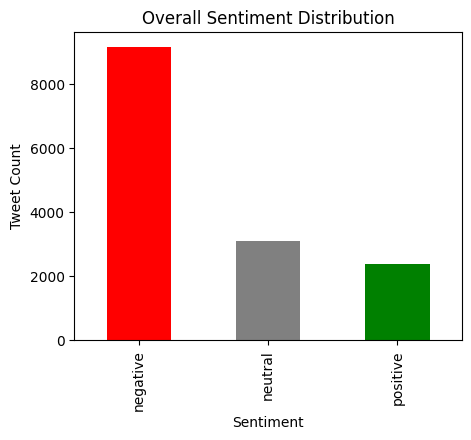

In [41]:
# Visualize overall sentiment distribution
plt.figure(figsize=(5,4))
df['label'].value_counts().plot(kind='bar', color=['red','gray','green'])
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

In [43]:
# Split Data
X = df['clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [44]:
# Train Models
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train_tfidf, y_train)

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

📊 Evaluation for Logistic Regression
Accuracy: 0.7708

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.93      0.86      1834
     neutral       0.63      0.45      0.52       617
    positive       0.79      0.57      0.67       472

    accuracy                           0.77      2923
   macro avg       0.74      0.65      0.68      2923
weighted avg       0.76      0.77      0.76      2923

📊 Evaluation for Naive Bayes
Accuracy: 0.7171

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1834
     neutral       0.72      0.22      0.33       617
    positive       0.88      0.33      0.48       472

    accuracy                           0.72      2923
   macro avg       0.77      0.51      0.55      2923
weighted avg       0.74      0.72      0.66      2923



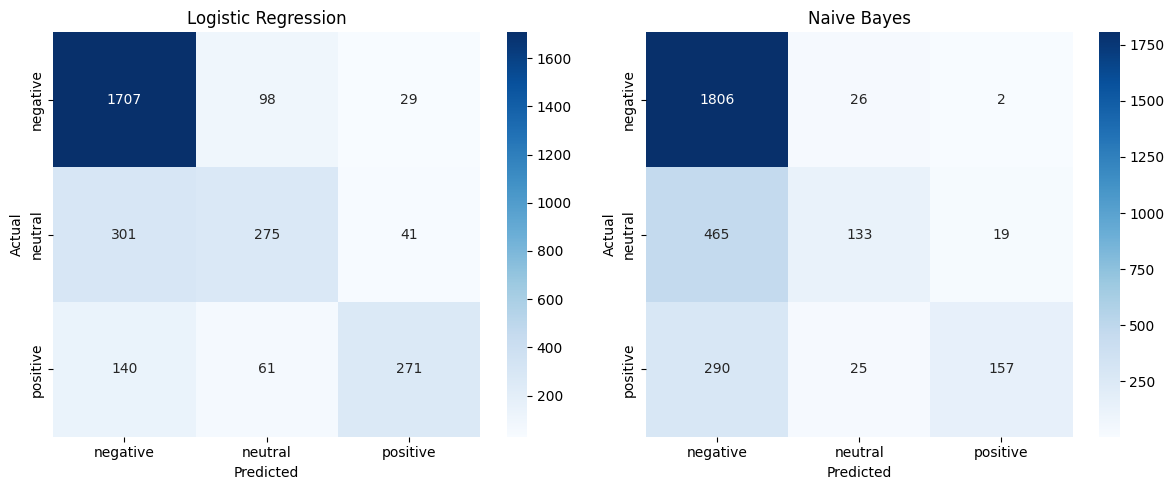

In [45]:
def eval_model(model, Xt, yt, name="Model"):
    preds = model.predict(Xt)
    acc = accuracy_score(yt, preds)
    print("=" * 60)
    print(f"📊 Evaluation for {name}")
    print("=" * 60)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(yt, preds))
    return preds, confusion_matrix(yt, preds)

# Evaluate both models
lr_preds, lr_cm = eval_model(lr, X_test_tfidf, y_test, "Logistic Regression")
nb_preds, nb_cm = eval_model(nb, X_test_tfidf, y_test, "Naive Bayes")

# Plot both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)),
            ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)),
            ax=axes[1])
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

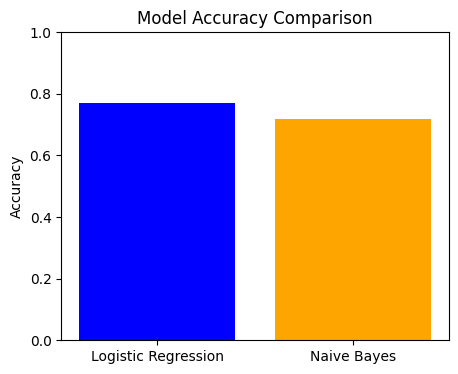

In [47]:
# Model accuracy comparison
accuracies = {
    "Logistic Regression": accuracy_score(y_test, lr.predict(X_test_tfidf)),
    "Naive Bayes": accuracy_score(y_test, nb.predict(X_test_tfidf))
}
plt.figure(figsize=(5,4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue','orange'])
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.show()

In [48]:
# Save model and vectorizer
joblib.dump(vectorizer, VECT_OUT)
joblib.dump(lr, MODEL_OUT)

print("\n✅ Saved vectorizer ->", VECT_OUT)
print("✅ Saved model ->", MODEL_OUT)


✅ Saved vectorizer -> tfidf_vectorizer_airline.joblib
✅ Saved model -> airline_sentiment_lr.joblib


In [49]:
# Predict function
def predict_text(text):
    tclean = clean_text(text)
    vec = vectorizer.transform([tclean])
    pred = lr.predict(vec)[0]
    probs = lr.predict_proba(vec)[0]
    prob_dict = dict(zip(lr.classes_, probs))
    return pred, prob_dict

# Topic-based Sentiment Analysis
def analyze_topic(topic, data=df, model=lr, vect=vectorizer):
    """
    Filters tweets that mention a specific topic (like 'AI', 'sports', 'delay')
    and analyzes the sentiment distribution.
    """
    topic_tweets = data[data['clean'].str.contains(topic.lower(), na=False)]
    if topic_tweets.empty:
        print(f"\nNo tweets found about '{topic}'.")
        return

    # Predict sentiments
    X_topic = vect.transform(topic_tweets['clean'])
    preds = model.predict(X_topic)
    topic_tweets = topic_tweets.copy()
    topic_tweets['predicted_sentiment'] = preds

    # Print distribution
    print(f"\nSentiment distribution for topic '{topic}':")
    sentiment_counts = topic_tweets['predicted_sentiment'].value_counts(normalize=True) * 100
    print(sentiment_counts)

    # Plot bar chart for topic sentiment
    sentiment_counts.plot(
        kind='bar',
        color=['red', 'gray', 'green'],
        figsize=(5, 4)
    )
    plt.title(f"Sentiment Distribution for Topic: {topic}")
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage")
    plt.show()

    return topic_tweets[['text', 'predicted_sentiment']].head(10)


Sample prediction: ('negative', {'negative': np.float64(0.8933138999941826), 'neutral': np.float64(0.03536361104674907), 'positive': np.float64(0.07132248895906833)})

Sentiment distribution for topic 'delay':
predicted_sentiment
negative    96.666667
positive     1.979167
neutral      1.354167
Name: proportion, dtype: float64


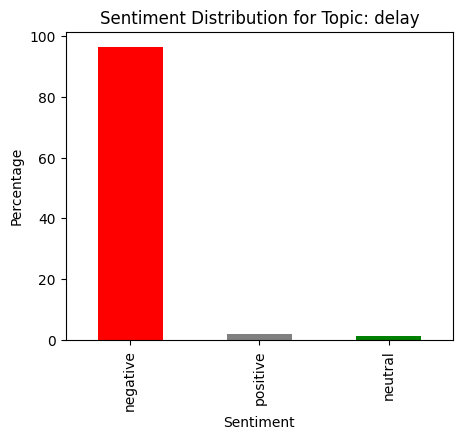

In [50]:
# Example usage
if __name__ == "__main__":
    sample = "The flight delay was terrible, but the staff was nice."
    print("\nSample prediction:", predict_text(sample))

    analyze_topic("delay")  # analyze tweets mentioning 'delay'